# **Context**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The datasets consists of several medical predictor variables and one target variable - "Outcome". 
Predictor variables includes:

1. "Pregnancies" - the number of pregnancies the patient has had.

2. "Glucose" - plasma glucose concentration a 2 hours in an oral glucose tolerance test.

    References:
    * The 2-hour plasma glucose level <140 mg/dL is considered normal. 
    * The 2-hour plasma glucose level of 140-199 mg/dL indicates impaired glucose tolerance. 
    * The 2-hour plasma glucose level ≥200 mg/dL indicates diabetes.
        

3. "BloodPressure" - diastolic blood pressure (mm Hg).

    References:
    * hypotension - less than 60 mm Hg
    * Normal - 60-80 mm Hg
    * At Risk (prehypertension) - 80-89 mm Hg
    * High Blood Pressure (hypertension) - 90 mm Hg or higher


4. "SkinThickness" - triceps skin fold thickness (mm).
    References: the range of skin + subcutaneous tissue thickness at arm is 4.90-21.00 mm in females

5. "Insulin" - 2-hour serum insulin (mu U/ml).
    References: 16-166 mIU/L

6. "BMI" - body mass index (weight in kg/(height in m)^2).

    References:
    * Underweight - less than 18.5 
    * Normal weight - 18.5-24.9 
    * Overweight - 25-29.9 
    * Obese - over 30.0


7. "DiabetesPedigreeFunction" - diabetes pedigree function. Provides some information on the history in relatives. This is a measure of genetic influence.

8. "Age" (years).


# **Project objectives** ¶

1. Prepare the data for analysis:

    * Check the indexing.
    * If present - remove duplicates, correct incorrect data types and wrong entries, process outliers, fill empty cells.
    

2. To determine which of the predictors have the most significant influence on the development of diabetes in women.

In [143]:
# Import necessary libraries
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# Jupyter magic command to display plots inline 
%matplotlib inline  
  
# Define the file path of the diabetes dataset
diabetes_filepath = "/kaggle/input/pima-indians-diabetes-database/diabetes.csv"

# Read the dataset from the file into a variable called diabetes_data
diabetes_data = pd.read_csv(diabetes_filepath)  

# Display the first few rows of the dataset
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


# **Data Cleaning** 

In [144]:
# Check data for duplicates
duplicates = diabetes_data.duplicated().sum()
duplicates

0

There are no duplicates in this dataset.

In [145]:
# Checking for nulls and data format
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Data formats are correct, and at first glance, nulls are absent.

In [146]:
# Set the display format for float values to show two decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

# Display summary statistics of the diabetes_data DataFrame
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


Here, we observe that in the columns 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', and 'BMI', the minimum value is 0, which is physically impossible. From this, we hypothesize that missing values were previously replaced with actual zeros. Unfortunately, we cannot track such replacements in the 'Pregnancies' and 'Outcome' columns, as zeros are valid in this context.

In [147]:
# Checking how many actual zeros are in the columns where their presence is impossible
zeros_count = (diabetes_data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0).sum()
zeros_count

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

It turns out there are quite a few missing values in this dataset, especially in the 'SkinThickness' and 'Insulin' columns.
Let's visualize it for better understanding.

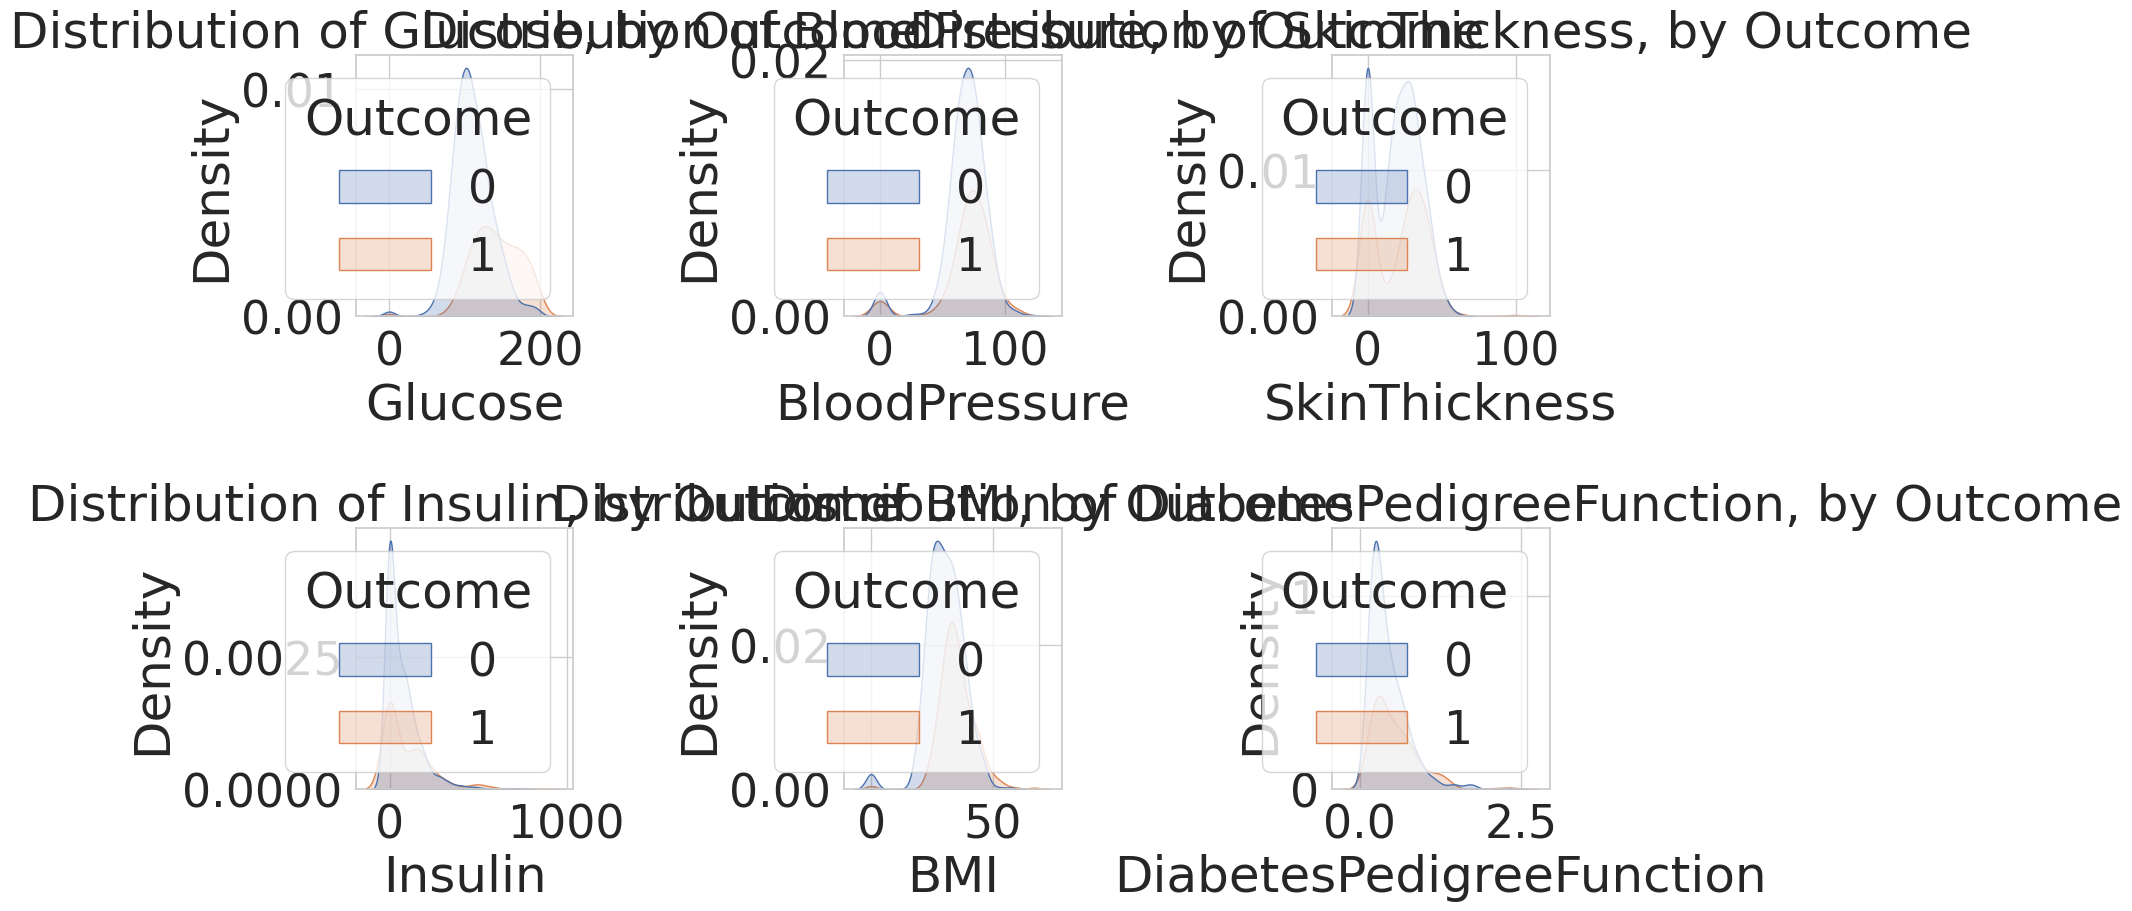

In [148]:
def plot_distributions_by_outcome(data, columns, clf_col):
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Create multiple plots
    for i, column in enumerate(columns):
        # Determine subplot indices
        row = i // 3
        col = i % 3

        # Create a distribution plot
        sns.kdeplot(data=data, x=column, hue=clf_col, fill=True, ax=axes[row, col])

        # Add title
        axes[row, col].set_title(f"Distribution of {column}, by {clf_col}")

    # Set compact layout
    plt.tight_layout()

    # Show the plots
    plt.show()

# Usage:
plot_distributions_by_outcome(
    diabetes_data, 
    ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction'], 
    'Outcome'
)

The zeros form distinct peaks on the histograms, which noticeably distorts the distribution shape. Moreover, it can be assumed that there are outliers in almost every column, and it seems that the sample of healthy women is significantly larger than the sample of women with diabetes.
Let's test the last assumption using a different visualization. 

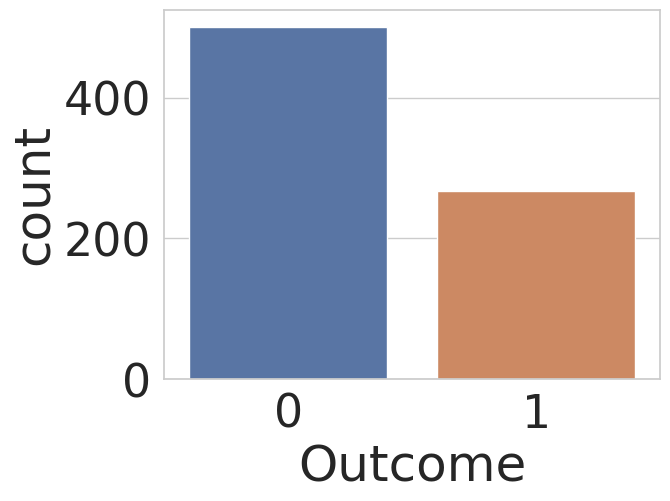

In [149]:
# Plot the count of each class in the 'Outcome' column
sns.countplot(x=diabetes_data['Outcome'], data=diabetes_data)
plt.show()

From this graph, it's evident that the groups are not equal. There are about half as many women with diagnosed diabetes compared to those without. The reason could be that missing data got mixed with real values.

Let's replace the zeros with NaNs.

In [150]:
# List of columns where zeros should be replaced with NaN
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with NaN in the specified columns
diabetes_data[columns_to_replace] = diabetes_data[columns_to_replace].replace(0, np.nan)

# Check the count of NaN values in each column
diabetes_data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

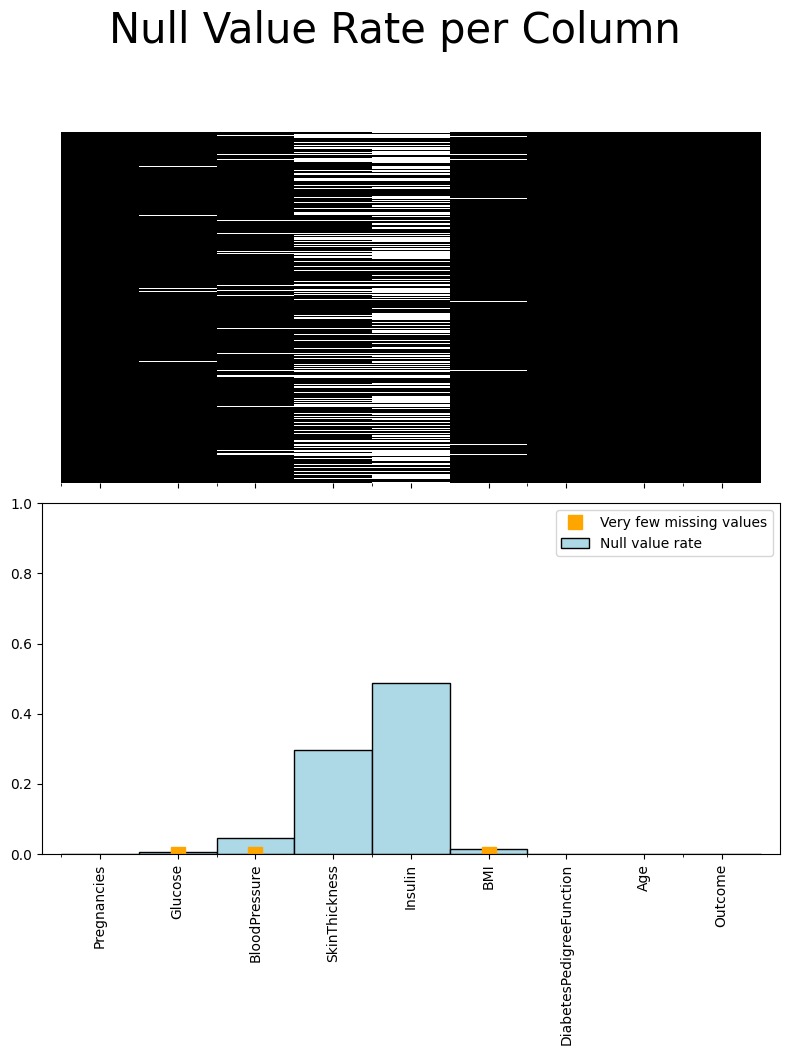

In [151]:
def nullscan(df_check, save=False):
    '''
    df_check: DataFrame to perform the nullscan on
    save: flag to determine if you want to save the plot as .png
    
    This function plots the rate of null values per column in a DataFrame using 
    a seaborn heatmap and a barplot.
    '''    
    # Create a DataFrame of booleans indicating null values
    df_nulls = df_check.isna()
    
    # Calculate the proportion of null values per column
    nulls_per_col = df_nulls.sum(axis=0)
    nulls_per_col /= len(df_check.index)

    # Set the default style for plots
    with plt.style.context('default'):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 10))
        
        # Create the heatmap of null values
        sns.heatmap(df_check.isnull(), cmap='gray', cbar=False, yticklabels=False, ax=ax1)
    
        # Create the barplot of null value rates
        nulls_per_col.plot(kind='bar', color='lightblue', x=nulls_per_col.values,  # Adjusted color
                           y=nulls_per_col.index, ax=ax2, width=1, linewidth=1, 
                           edgecolor='black', align='edge', label='Null value rate')
        
        # Set the y-axis limits for the barplot
        ax2.set_ylim((0,1))
        
        # Set the x-axis ticks and labels
        labels=df_check.columns
        ticks = np.arange(0.5, len(labels))
        ax2.xaxis.set(ticks=ticks, ticklabels=labels)
        
        # Set the color of the top and right spines to black
        ax2.spines['top'].set_color('black')
        ax2.spines['right'].set_color('black')
        
        # Add markers for columns with very few missing values
        na_ticks = ticks[(nulls_per_col > 0) & (nulls_per_col < 0.05)]
        if (len(na_ticks) > 0):
            ax2.plot(na_ticks, [0,]*len(na_ticks), 's', c='orange', markersize=10,  # Adjusted color
                     label='Very few missing values')
    
        # Add a title to the figure
        fig.suptitle('Null Value Rate per Column', fontsize=30, y=1.05)
        
        # Add a legend to the barplot
        ax2.legend()
        
        # Adjust the layout of the figure
        fig.tight_layout() 
        
        # Save the figure as a .png file if save flag is True
        if(save):
            plt.savefig('nullscan.png')
        
        # Show the plot
        plt.show()
        

# Call the nullscan function, passing the diabetes_data DataFrame
nullscan(diabetes_data)


Remove rows with 3 or more missing values, as they are less informative.

In [152]:
diabetes_data = diabetes_data.dropna(thresh=7)

# Check for missing values again
diabetes_data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                 2
SkinThickness               192
Insulin                     339
BMI                           2
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

As I have already noted, there is a high probability that missing values in the 'Outcome' column got mixed with actual zeros. It is very likely that women with glucose and insulin levels higher than 140 and 166 respectively, as well as those with excess body mass, have diabetes. Therefore, for such cases, we will change the value in the 'Outcome' column to 1.
In other cases, it is quite difficult to restore the data without being a medical specialist or knowing more advanced tools, so we won't go further into that for now.

In [153]:
diabetes_data.loc[
    (diabetes_data['Outcome'] == 0) & (diabetes_data['Glucose'] >= 140) & 
    (diabetes_data['Insulin'] >= 166) & (diabetes_data['BMI'] >= 25),
    'Outcome'] = 1

In [154]:
# Calculate the percentage of NaN values in each column
(diabetes_data.isna().mean() * 100).round(2)

Pregnancies                 0.00
Glucose                     0.68
BloodPressure               0.27
SkinThickness              26.19
Insulin                    46.25
BMI                         0.27
DiabetesPedigreeFunction    0.00
Age                         0.00
Outcome                     0.00
dtype: float64

Since the columns 'Glucose', 'BloodPressure', 'BMI' have a small number of missing values (less than 10%), we can replace them with the mode.

In [155]:
def replace_NaNs_with_mode(dataframe, condition_column, condition_value, target_column):
    # Find the mode for target_column among rows where condition_column == condition_value
    mode = dataframe[dataframe[condition_column] == condition_value][target_column].mode()[0]

    # Replace zeros in target_column only for rows where condition_column == condition_value
    dataframe.loc[(dataframe[target_column].isna()) & (dataframe[condition_column] == condition_value), target_column] = mode

    # Return the updated DataFrame
    return dataframe

for column in ['Glucose', 'BloodPressure', 'BMI']:
    for outcome in [0, 1]:
        diabetes_data = replace_NaNs_with_mode(diabetes_data, 'Outcome', outcome, column)

# Check the number of missing values after imputation
for column in ['Glucose', 'BloodPressure', 'BMI']:
    print(f"Number of missing values in '{column}' column: {diabetes_data[column].isnull().sum()}")

Number of missing values in 'Glucose' column: 0
Number of missing values in 'BloodPressure' column: 0
Number of missing values in 'BMI' column: 0


Before addressing the issue of missing data in the 'Insulin' and 'SkinThickness' columns, let's examine the pairwise correlations.

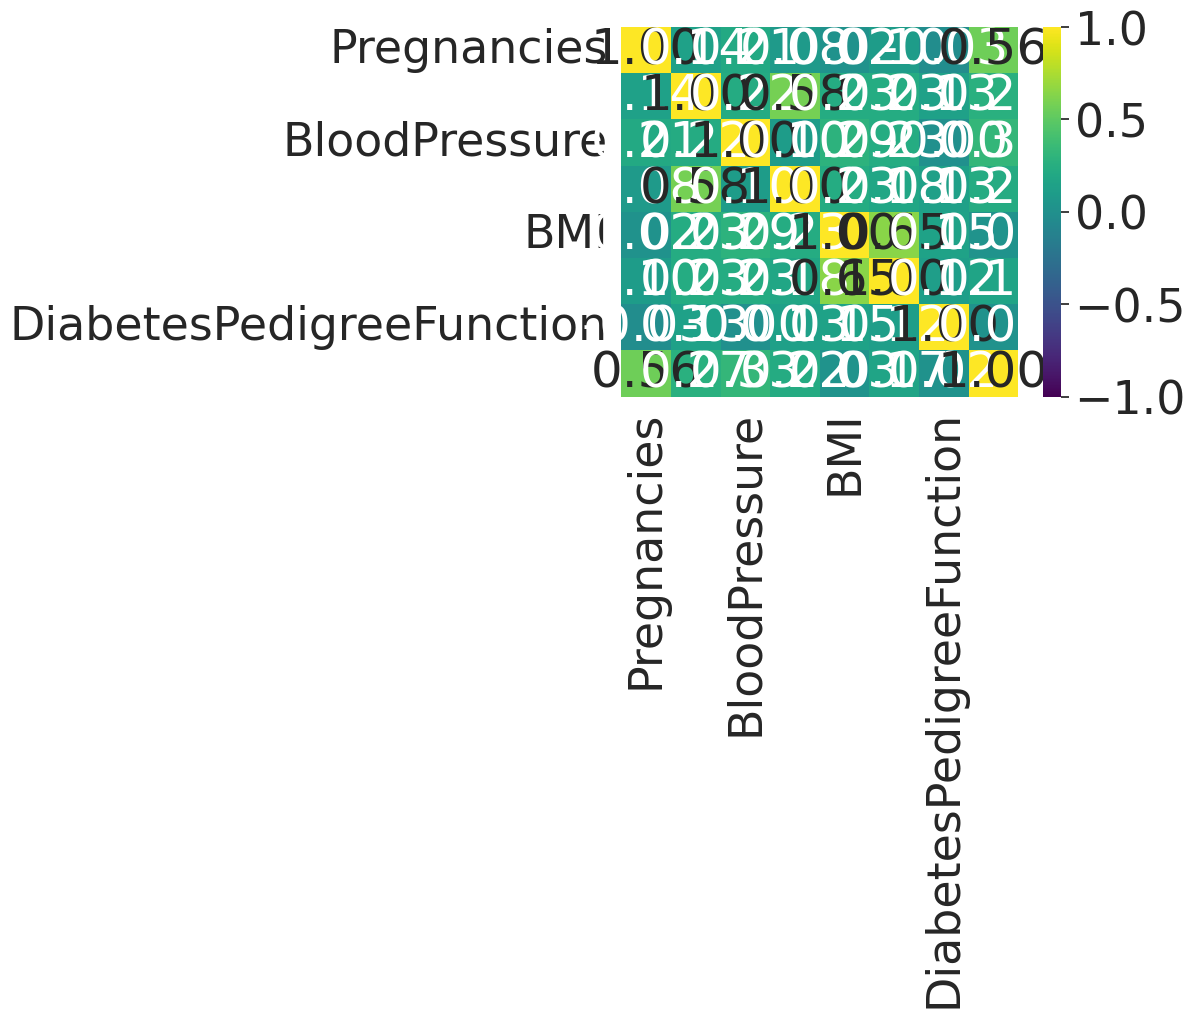

In [156]:
sns.heatmap(
    diabetes_data[['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'SkinThickness', 'DiabetesPedigreeFunction', 'Age']].corr(), 
    vmax=1, 
    vmin=-1, 
    annot=True, 
    cmap='viridis', 
    fmt=".2f"
);

From the heatmap, it is evident that there is a moderate correlation between the features 'Glucose' and 'Insulin', 'BMI' and 'SkinThickness', 'Pregnancies' and 'Age'. Let's create scatter plots and visually analyze the relationship between them.

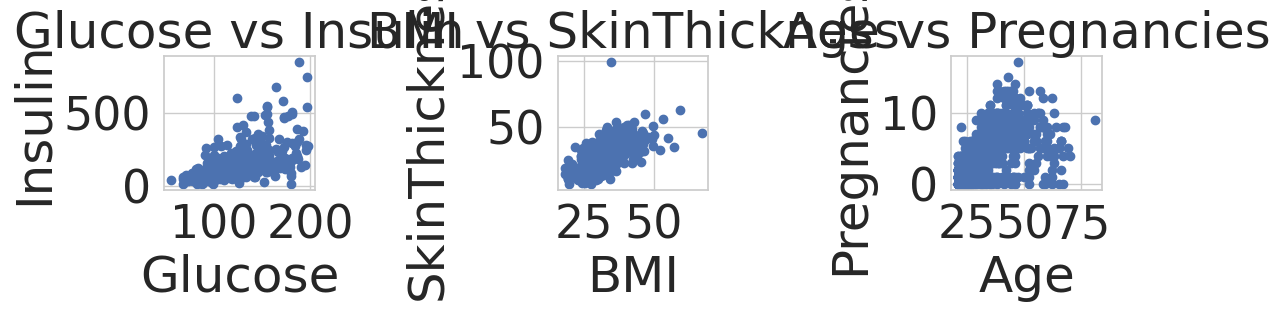

In [157]:
# Creating plots in a single row
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Constructing the first scatter plot: 'Glucose' and 'Insulin'
axes[0].scatter(diabetes_data['Glucose'], diabetes_data['Insulin'])
axes[0].set_xlabel('Glucose')
axes[0].set_ylabel('Insulin')
axes[0].set_title('Glucose vs Insulin')

# Constructing the second scatter plot: 'BMI' and 'SkinThickness'
axes[1].scatter(diabetes_data['BMI'], diabetes_data['SkinThickness'])
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('SkinThickness')
axes[1].set_title('BMI vs SkinThickness')

# Constructing the third scatter plot: 'Age' and 'Pregnancies'
axes[2].scatter(diabetes_data['Age'], diabetes_data['Pregnancies'])
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Pregnancies')
axes[2].set_title('Age vs Pregnancies')

plt.tight_layout()  # Adjusting the layout of plots
plt.show()  # Displaying the plots

Excluding some noticeable outliers, a truly linear relationship exists only between the features 'BMI' and 'SkinThickness'

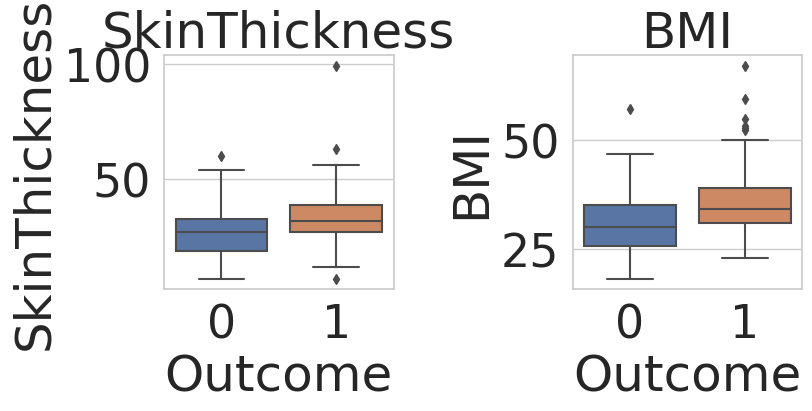

In [158]:
def plot_boxplots(data, columns, clf_col):
    '''
    Function to create boxplots for numerical variables grouped by a specified variable.

    Parameters:
        data (DataFrame): The DataFrame containing the data.
        columns (list): List of numerical variables for which boxplots will be created.
        clf_col (str): The variable for grouping the data.

    Requires:
        - matplotlib.pyplot
        - seaborn

    Returns:
        None
    '''

    # Create subplots for each numerical variable
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
    axs = axs.flatten()

    # Iterate through numerical variables
    for i, var in enumerate(columns):
        # Create a boxplot for each variable, grouped by the specified variable
        sns.boxplot(x=clf_col, y=var, data=data, ax=axs[i])
        axs[i].set_title(var)  # Set the title of each subplot

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()

# Call the function with the diabetes_data DataFrame and the grouping variable
plot_boxplots(
    diabetes_data, 
    ['SkinThickness', 'BMI'], 
    'Outcome'
)

Despite the outliers (which I intentionally disregard as they won't hinder subsequent manipulations), one distribution distinctly mirrors the other. Therefore, the presence of an additional variable here doesn't add extra information. Hence, it's safe to remove one of them, specifically the variable with numerous missing values.

In [159]:
diabetes_data = diabetes_data.drop('SkinThickness', axis=1)

The next step is to determine if there are significant differences between individuals with diabetes and healthy individuals across all parameters. This is important because the absence of statistical differences between these groups also raises questions about the importance of considering this feature in the analysis.
Due to the unevenness in group sizes, we will use the non-parametric Mann-Whitney test.

In [160]:
from scipy import stats

healthy = diabetes_data.query('Outcome == 0').drop('Outcome', axis=1)
diabetics = diabetes_data.query('Outcome == 1').drop('Outcome', axis=1)

# Performing Mann-Whitney U test for each column between healthy and diabetic groups
for column in ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']:
    # Calculate Mann-Whitney U test statistics and p-value
    stat, p = stats.mannwhitneyu(healthy[column], diabetics[column])
    
    # Display the results for each column
    print(column)
    print("U =", stat)  # Mann-Whitney U test statistic
    print("p-value =", p)  # p-value
    print()

Pregnancies
U = 48202.0
p-value = 1.157787122000558e-07

Glucose
U = 22229.5
p-value = 1.662836595050154e-48

BloodPressure
U = 49228.5
p-value = 9.615335771414068e-07

BMI
U = 38131.0
p-value = 5.718723494445922e-19

DiabetesPedigreeFunction
U = 48010.0
p-value = 9.678561404520712e-08

Age
U = 39759.5
p-value = 8.812882900600567e-17



In all cases, the p-value is less than 0.05, indicating that there are statistically significant differences.

Next, we'll transform our numerical features into categorical ones. This will solve several issues at once:

* Address the problem of outliers.
* Simplify the process of handling missing values in the 'Insulin' column.
* Ease the subsequent analysis.

In [163]:
# Create a new categorical column 'Age_category' based on the 'Age' column
diabetes_data["Age_cat"] = pd.cut(
    x=diabetes_data["Age"],  
    bins=[20, 30, 40, 50, 60, 70, 80, 90],  # Define age bins
    labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']  # Label categories for age ranges
)

# Create a new categorical column 'BMI_category' based on the 'BMI' column
diabetes_data["BMI_cat"] = pd.cut(
    x=diabetes_data["BMI"], 
    bins=[-np.inf, 18.5, 25.0, 30.0, np.inf],  # Define BMI bins
    labels=['Underweight', 'Normal Weight', 'Overweight', 'Obese']  # Label categories for BMI ranges
)

# Creating categories based on 'BloodPressure' column values
diabetes_data['BloodPressure_cat'] = pd.cut(
    diabetes_data['BloodPressure'], 
    bins=[-np.inf, 60, 80, 90, np.inf],  # Define blood pressure bins
    labels=['Hypotension', 'Normal', 'Prehypertension', 'Hypertension']  # Label categories for blood pressure ranges
)

# Creating categories based on 'Glucose' column values
diabetes_data['Glucose_cat'] = pd.cut(
    diabetes_data['Glucose'],  
    bins=[-np.inf, 140, 200, np.inf],  # Define glucose bins
    labels=['Normal', 'High', 'Very-High']  # Label categories for glucose ranges
)

# Creating categories based on 'Insulin' column values
diabetes_data['Insulin_cat'] = pd.cut(
    diabetes_data['Insulin'],  
    bins=[-np.inf, 16, 166, np.inf],  # Define insulin bins
    labels=['Low', 'Normal', 'High']  # Label categories for insulin levels
)

# Creating categories based on 'DiabetesPedigreeFunction' column values
diabetes_data['DiabetesPedigreeFunction_cat'] = pd.cut(
    diabetes_data['DiabetesPedigreeFunction'],  
    bins=[-np.inf, 0.61, 0.9, np.inf],  # Define diabetes pedigree function bins
    labels=['Normal', 'High', 'Very-High']  # Label categories for diabetes pedigree function levels
)

# Define a list of features including the newly created categorical columns
features = [
    'Pregnancies', 'Outcome', 'Age_cat', 'BMI_cat', 'BloodPressure_cat', 'Glucose_cat', 'Insulin_cat',
    'DiabetesPedigreeFunction_cat'
]

# Display the first few rows of the DataFrame with the new categorical columns
diabetes_data[features].head()


,Pregnancies,Outcome,Age_cat,BMI_cat,BloodPressure_cat,Glucose_cat,Insulin_cat,DiabetesPedigreeFunction_cat
0,6,1,40-50,Obese,Normal,High,NaN,High
1,1,0,30-40,Overweight,Normal,Normal,NaN,Normal
2,8,1,30-40,Normal Weight,Normal,High,NaN,High
3,1,0,20-30,Overweight,Normal,Normal,Normal,Normal
4,0,1,30-40,Obese,Hypotension,Normal,High,Very-High


Also, let's introduce labels.

In [164]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

# Using LabelEncoder for specific categorical columns and creating new encoded columns
for feature in ['Age_cat', 'BMI_cat', 'BloodPressure_cat', 'Glucose_cat', 'DiabetesPedigreeFunction_cat']:
    label_encoders[feature] = LabelEncoder()  # Initializing LabelEncoder for the feature
    # Transforming and adding encoded values as new columns with '_lb' suffix
    diabetes_data[f'{feature}_lb'] = label_encoders[feature].fit_transform(diabetes_data[feature])

# Mapping 'Insulin_cat' categories to numerical values and creating a new column
diabetes_data['Insulin_cat_lb'] = diabetes_data['Insulin_cat'].map({
    'Low': 0, 'Normal': 1, 'High': 2  # Mapping categorical values to numerical labels
})

# Defining a list of features including the newly created encoded categorical columns
features_lb = [
    'Outcome', 'Pregnancies', 'Age_cat_lb', 'BMI_cat_lb', 'BloodPressure_cat_lb',
    'Glucose_cat_lb', 'Insulin_cat_lb', 'DiabetesPedigreeFunction_cat_lb'
]

# Displaying the first few rows of the DataFrame with the new encoded categorical columns
diabetes_data[features_lb].head()


,Outcome,Pregnancies,Age_cat_lb,BMI_cat_lb,BloodPressure_cat_lb,Glucose_cat_lb,Insulin_cat_lb,DiabetesPedigreeFunction_cat_lb
0,1,6,2,1,2,0,NaN,0
1,0,1,1,2,2,1,NaN,1
2,1,8,1,0,2,0,NaN,0
3,0,1,0,2,2,1,1,1
4,1,0,1,1,1,1,2,2


Let's train an auxiliary model to fill in the missing values in the 'Insulin' column.

In [165]:
# Selecting specific features for the classifier
clf_features = diabetes_data[[
    'Pregnancies', 'Outcome', 'Age_cat_lb', 'BMI_cat_lb', 'BloodPressure_cat_lb',
    'Glucose_cat_lb', 'Insulin_cat_lb', 'DiabetesPedigreeFunction_cat_lb'
]]

# Creating a boolean mask to identify missing values in 'Insulin_cat_lb' column
missing_mask = clf_features['Insulin_cat_lb'].isna()

# Extracting data for the instances with missing 'Insulin_cat_lb' values
X_missing = clf_features[missing_mask].drop('Insulin_cat_lb', axis=1)

# Extracting data for the instances without missing 'Insulin_cat_lb' values
X = clf_features[~missing_mask].drop('Insulin_cat_lb', axis=1)

# Extracting target variable 'Insulin_cat_lb' for instances without missing values
y = clf_features.Insulin_cat_lb[~clf_features.Insulin_cat_lb.isna()]

In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

Model selection.

In [167]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Training models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=42)
}

results = {}

# Loop through models and train each model, then evaluate performance
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    
    # Calculate evaluation metrics (Accuracy, Precision, Recall, F1 Score)
    accuracy = (accuracy_score(y_test, y_pred)).round(2)
    precision = (precision_score(y_test, y_pred, average='micro')).round(2)
    recall = (recall_score(y_test, y_pred, average='micro')).round(2)
    f1 = (f1_score(y_test, y_pred, average='micro')).round(2)

    # Store results for each model
    results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

# Display results for each model
for name, result in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1 Score: {result['F1 Score']}")
    print("-----------")

Model: Random Forest
Accuracy: 0.7
Precision: 0.7
Recall: 0.7
F1 Score: 0.7
-----------
Model: Gradient Boosting
Accuracy: 0.74
Precision: 0.74
Recall: 0.74
F1 Score: 0.74
-----------
Model: K-Nearest Neighbors
Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1 Score: 0.72
-----------
Model: Support Vector Machine
Accuracy: 0.78
Precision: 0.78
Recall: 0.78
F1 Score: 0.78
-----------


Let's settle on the SVC model as it outperforms others across all metrics.

In [168]:
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
f'SVC score: {(svc.score(X_train, y_train)).round(2)}'

'SVC score: 0.78'

In [169]:
y_pred = svc.predict(X_test)
f1 = f1_score(y_test, y_pred, average='micro')
f'F1-score: {(f1).round(2)}'

'F1-score: 0.78'

In [170]:
# Predicting missing values
y_missing = svc.predict(X_missing)  # X_missing - data with missing values

# Creating a Series with predicted values and indices of missing places
predicted_values_series = pd.Series(y_missing, index=X_missing.index)

# Filling missing values in the 'age_labels' column with predicted values
diabetes_data['Insulin_cat_lb'].fillna(predicted_values_series, inplace=True)

diabetes_data[features_lb].info()

<class 'pandas.core.frame.DataFrame'>
Index: 733 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Outcome                          733 non-null    int64   
 1   Pregnancies                      733 non-null    int64   
 2   Age_cat_lb                       733 non-null    int64   
 3   BMI_cat_lb                       733 non-null    int64   
 4   BloodPressure_cat_lb             733 non-null    int64   
 5   Glucose_cat_lb                   733 non-null    int64   
 6   Insulin_cat_lb                   733 non-null    category
 7   DiabetesPedigreeFunction_cat_lb  733 non-null    int64   
dtypes: category(1), int64(7)
memory usage: 46.7 KB


In [171]:
diabetes_data['Insulin_cat_lb'] = diabetes_data['Insulin_cat_lb'].astype('int')

diabetes_data['Insulin_cat'] = diabetes_data['Insulin_cat_lb'].map({
    0: 'Low', 1: 'Normal', 2: 'High'
})

# **Data Analysis**

Once all missing values are filled, we can perform a visual analysis of the obtained features. I'll create histograms since the data is categorical, where the X-axis will represent the feature classes, and the Y-axis will depict their percentage distribution. I opted for percentages since the healthy and diabetic groups are not of equal size.

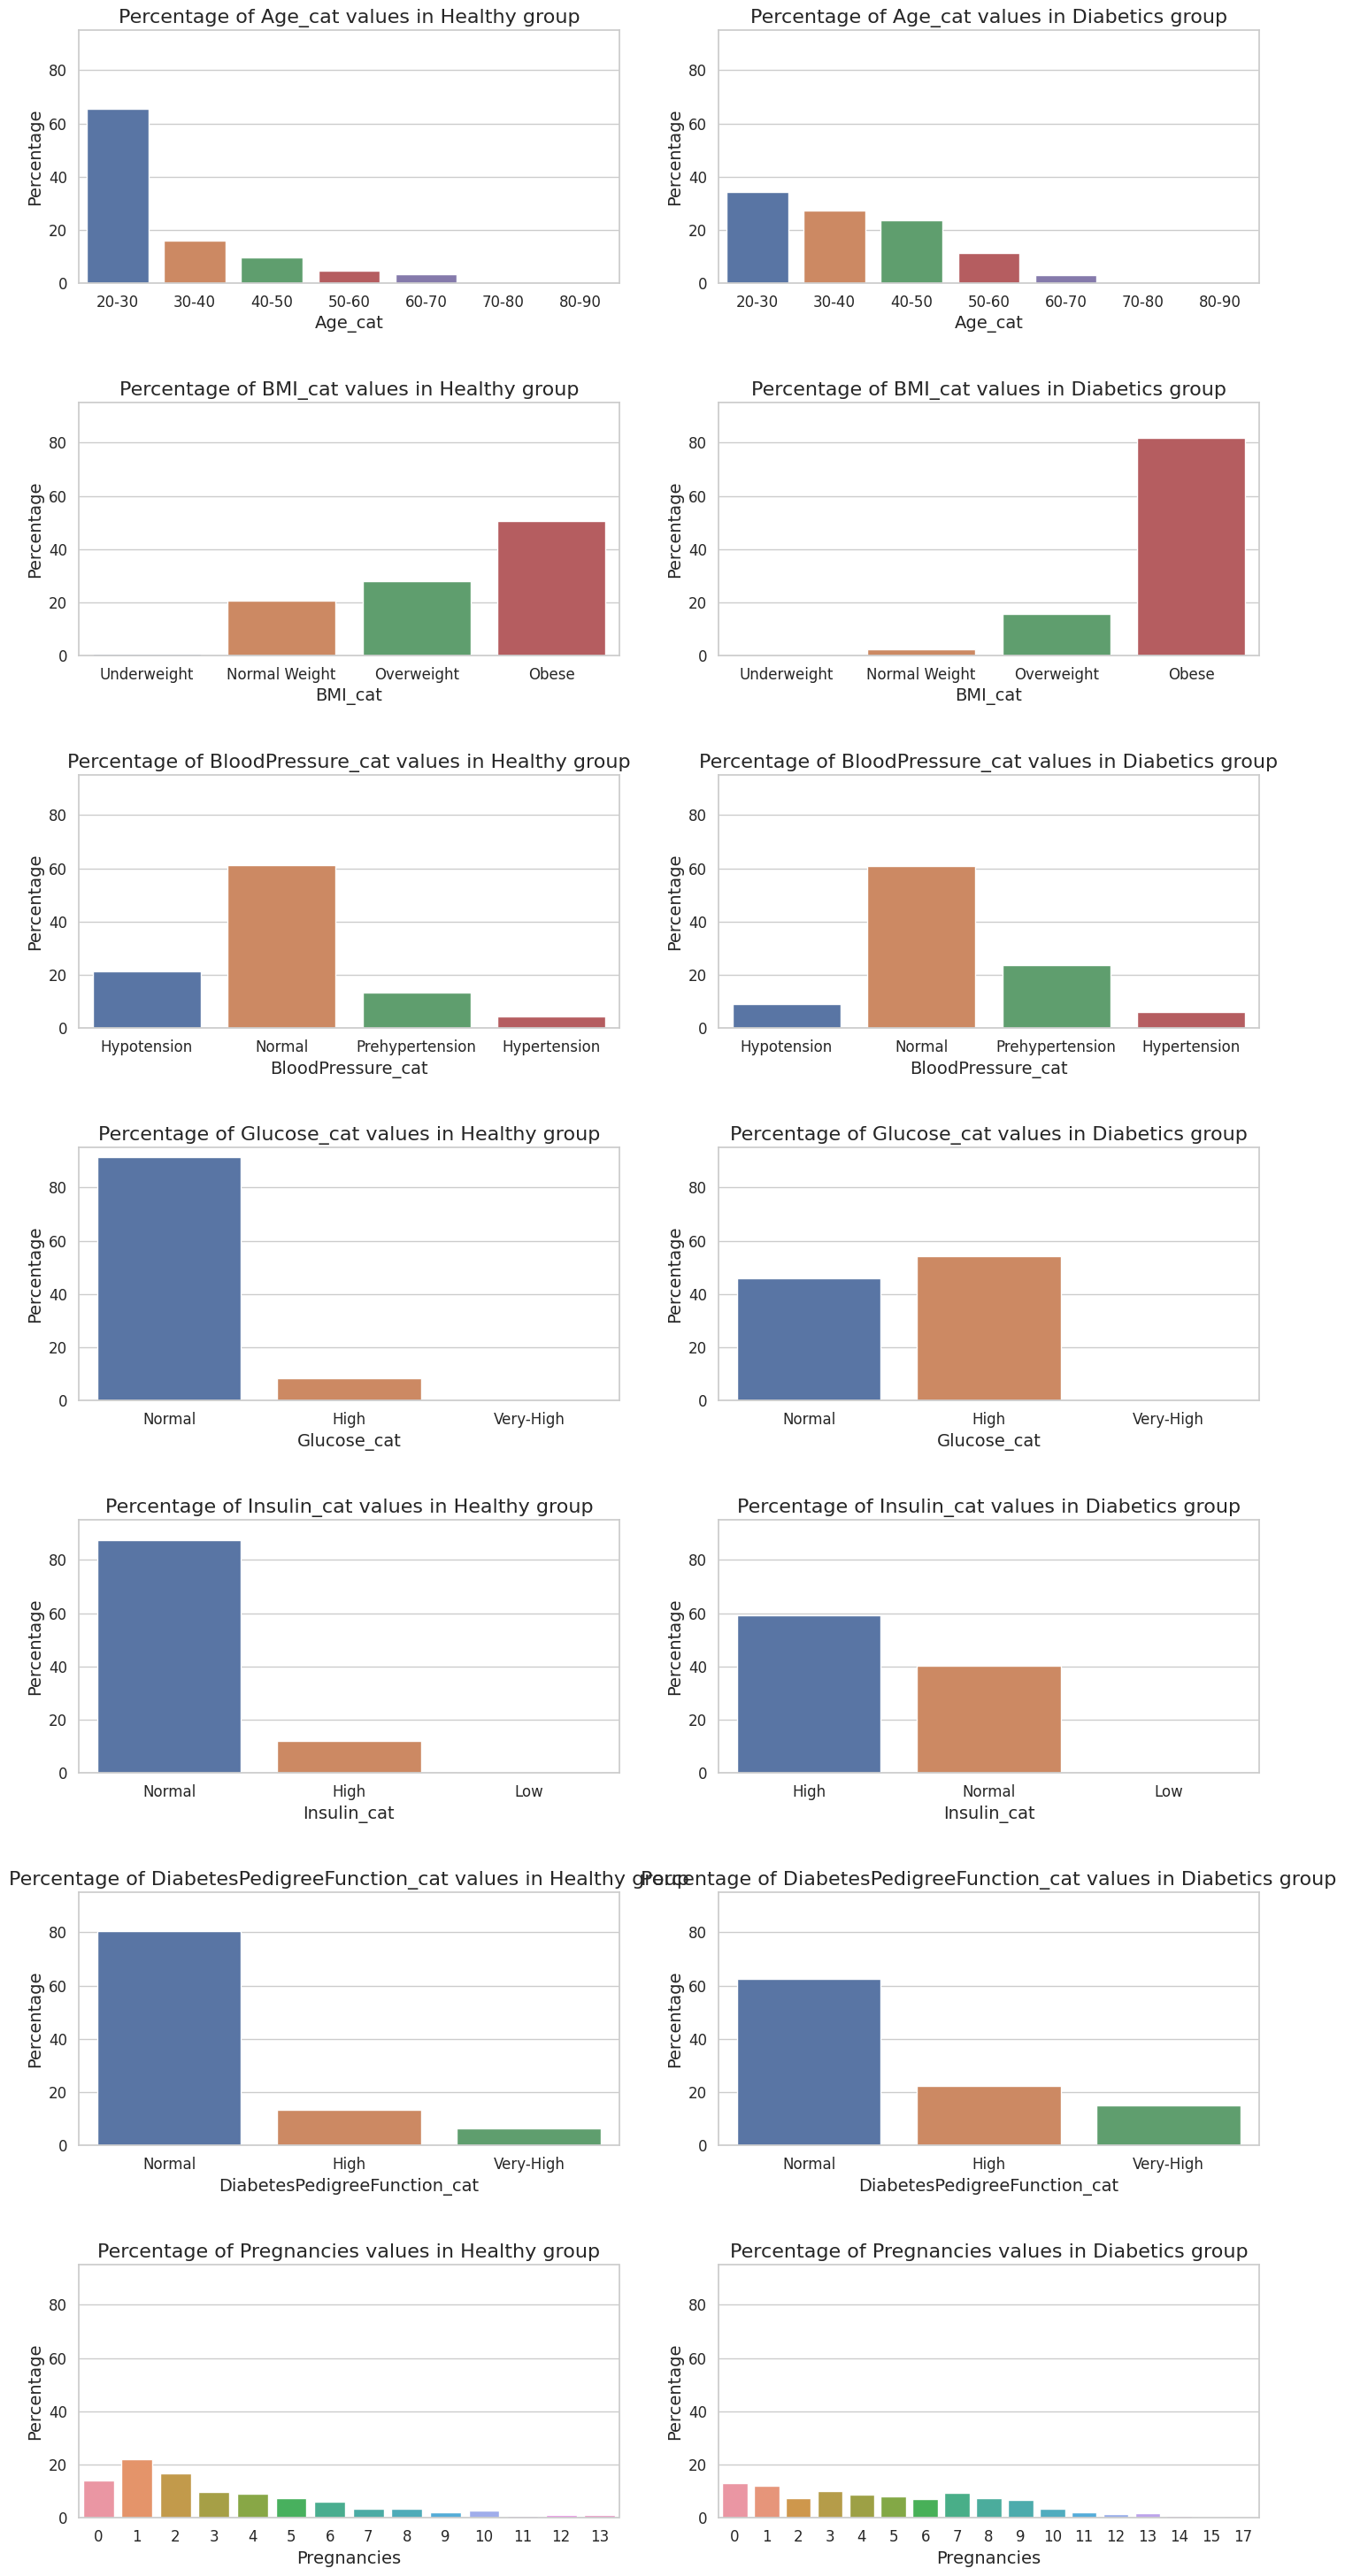

In [172]:
# Assuming 'healthy' and 'diabetics' are DataFrames with respective data

features = [
    'Outcome', 'Age_cat', 'BMI_cat', 'BloodPressure_cat', 'Glucose_cat', 'Insulin_cat', 
    'DiabetesPedigreeFunction_cat', 'Pregnancies'
]

healthy = diabetes_data[features].query('Outcome == 0').drop('Outcome', axis=1)
diabetics = diabetes_data[features].query('Outcome == 1').drop('Outcome', axis=1)

# Creating subplots for each feature comparison
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(15, 30))
axs = axs.flatten()

# Iterating through each column
for i, column in enumerate(healthy.columns):
    total_count_healthy = len(healthy[column])
    total_count_diabetics = len(diabetics[column])

    # Calculate percentages for the healthy group
    percent_healthy = (healthy[column].value_counts() / total_count_healthy) * 100
    ax = sns.barplot(x=percent_healthy.index, y=percent_healthy.values, ax=axs[i*2])
    ax.set_title(f'Percentage of {column} values in Healthy group', fontsize=16)
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Percentage', fontsize=14)
    ax.set_ylim(0, 95)
    ax.tick_params(labelsize=12)

    # Calculate percentages for the diabetics group
    percent_diabetics = (diabetics[column].value_counts() / total_count_diabetics) * 100
    ax = sns.barplot(x=percent_diabetics.index, y=percent_diabetics.values, ax=axs[i*2+1])
    ax.set_title(f'Percentage of {column} values in Diabetics group', fontsize=16)
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Percentage', fontsize=14)
    ax.set_ylim(0, 95)  
    ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

What can be said at first glance?

1. Women with diabetes are generally older than healthy individuals.
2. Diabetics suffer from obesity more frequently than healthy individuals, and there are very few people with normal body weight among them.
3. Among women with diabetes, high blood pressure is more common than low blood pressure.
4. Diabetics tend to have elevated levels of insulin and glucose more often than healthy individuals.
5. DiabetesPedigreeFunction is more frequently high among diabetics than low.
6. Among diabetics, there are more women who have given birth to multiple children.

Now let's train the Random Forest model and observe how it distributes the features based on their importance.

In [173]:
# Extracting the predictor matrix X and the target variable y
X = diabetes_data[features_lb].drop(['Outcome'], axis=1)
y = diabetes_data['Outcome']

Fitting 2 folds for each of 100 candidates, totalling 200 fits


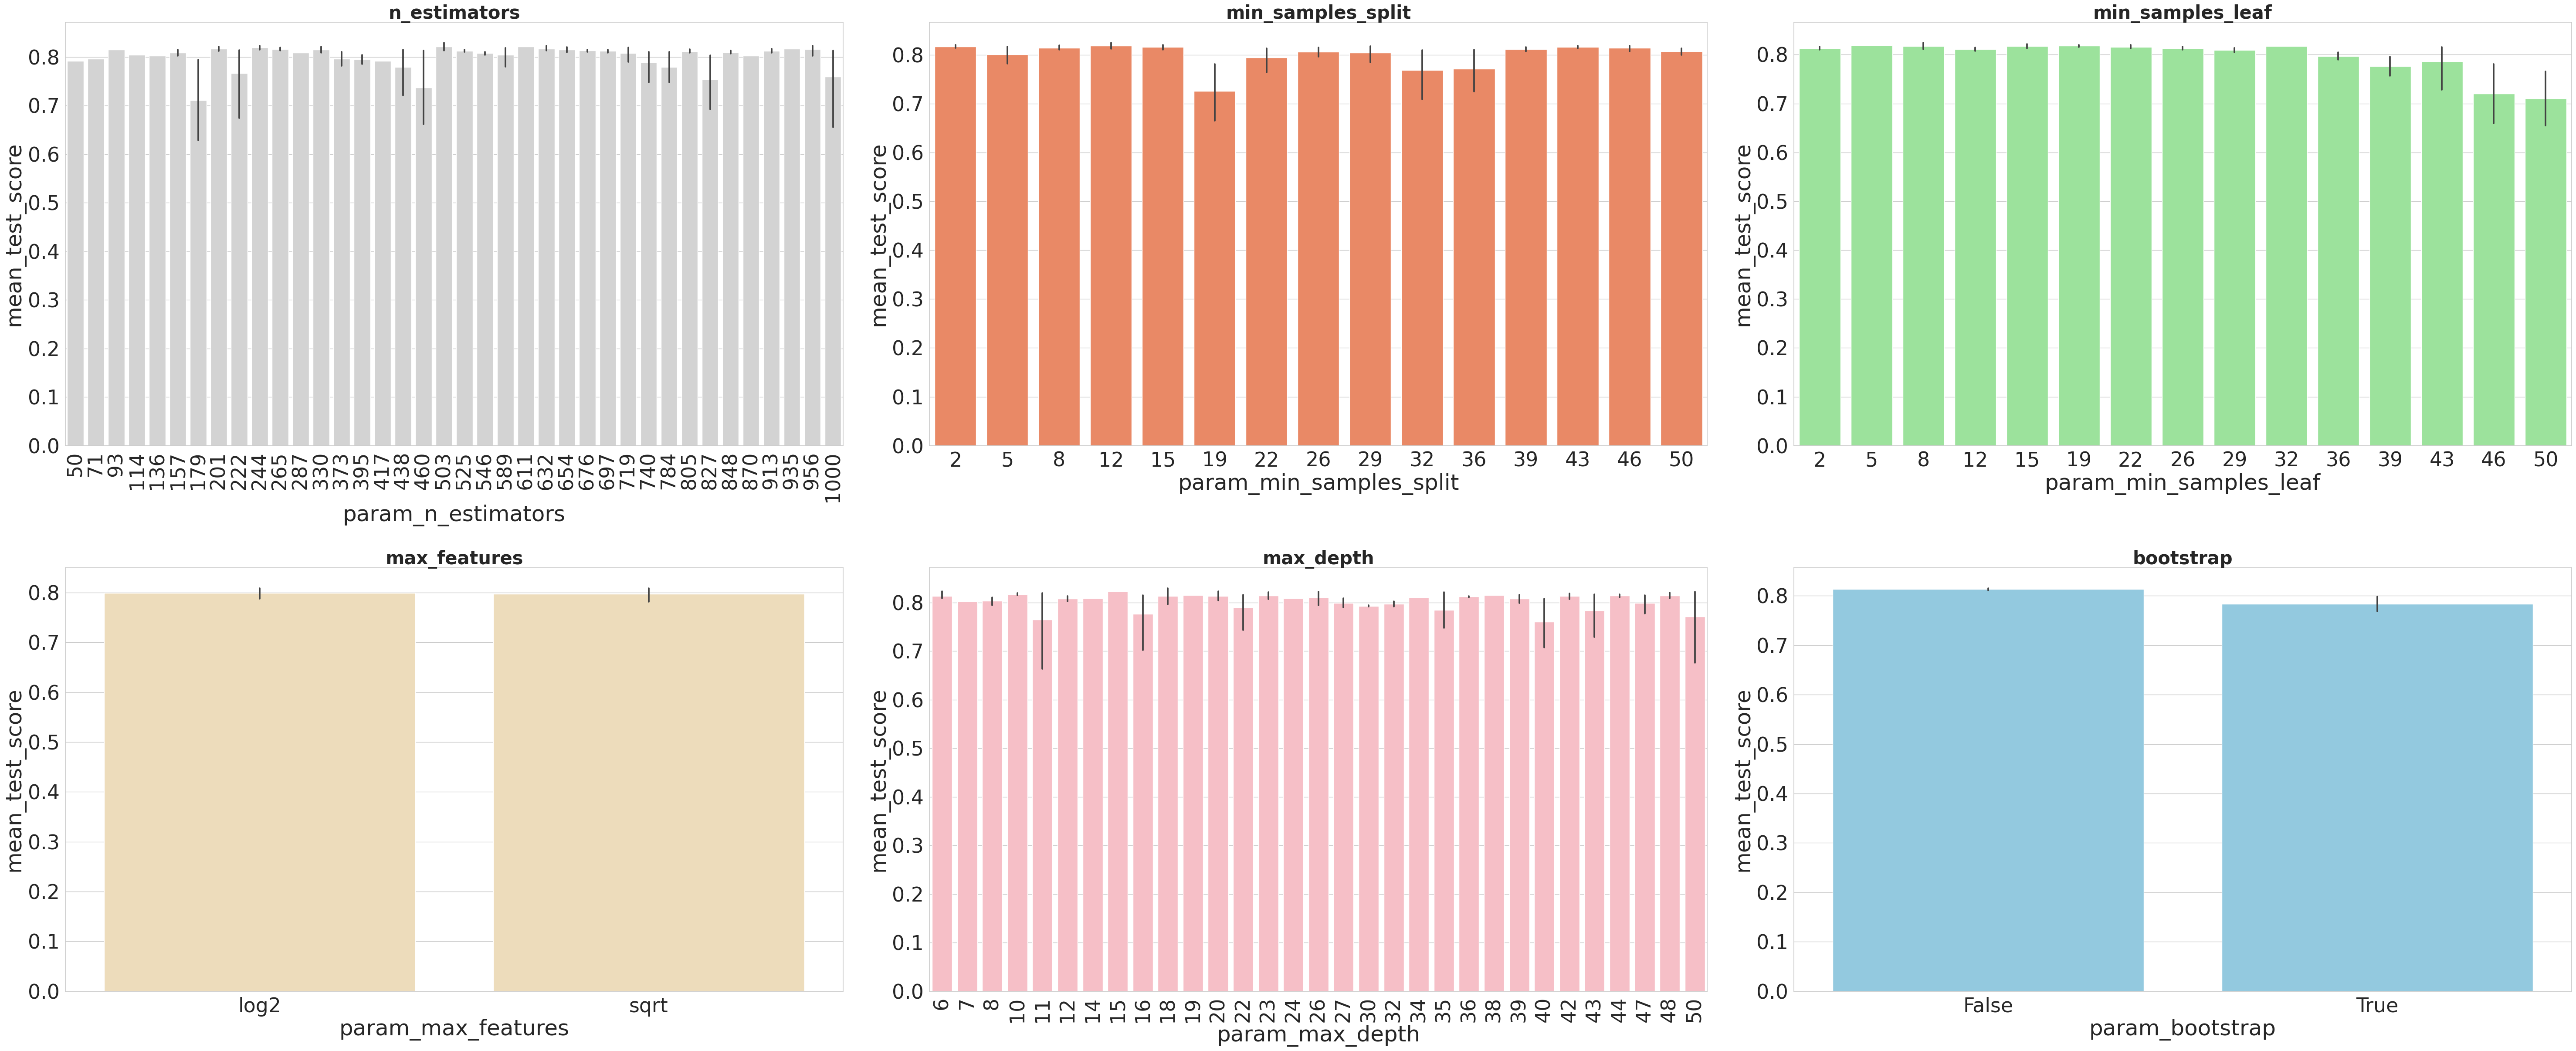

In [175]:
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

rfc = RandomForestClassifier(random_state=42)
        
# Defining the parameter distribution for hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=1000, num=45)],
    'max_depth': [int(x) for x in np.linspace(start=5, stop=50, num=35)],
    'min_samples_split': [int(x) for x in np.linspace(start=2, stop=50, num=15)],
    'min_samples_leaf': [int(x) for x in np.linspace(start=2, stop=50, num=15)],
    'max_features': ('log2', 'sqrt'),
    'bootstrap': (True, False)
}

# Initializing RandomizedSearchCV to search through the parameter space
rs = RandomizedSearchCV(
    estimator=rfc, 
    param_distributions=param_dist, 
    n_iter=100,  # Number of parameter settings that are sampled
    cv=2,  # Number of cross-validation folds
    verbose=1,  # Controls verbosity
    n_jobs=-1,  # Number of jobs to run in parallel (-1 uses all processors)
    random_state=42  # Setting a fixed random_state for reproducibility
)

# Fitting the RandomizedSearchCV to the training data to find the best parameters
rs.fit(X_train, y_train)

rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'std_test_score'],
            axis=1)

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale=3)
fig.set_size_inches(60, 25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0, 0], color='lightgrey')
axs[0, 0].set_title(label='n_estimators', size=30, weight='bold')
axs[0, 0].tick_params(axis='x', labelrotation=90)

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0, 1], color='coral')
axs[0, 1].set_title(label='min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0, 2], color='lightgreen')
axs[0, 2].set_title(label='min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1, 0], color='wheat')
axs[1, 0].set_title(label='max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1, 1], color='lightpink')
axs[1, 1].set_title(label='max_depth', size=30, weight='bold')
axs[1, 1].tick_params(axis='x', labelrotation=90)

sns.barplot(x='param_bootstrap', y='mean_test_score', data=rs_df, ax=axs[1, 2], color='skyblue')
axs[1, 2].set_title(label='bootstrap', size=30, weight='bold')

plt.tight_layout()

plt.show()

In [195]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(
    max_features='log2', 
    bootstrap=False, 
    random_state=42
)
parameters = {
    'max_depth': (13,),
    'min_samples_leaf': (5,),
    'min_samples_split': (2,),
    'n_estimators': (956,)
    }
grid_search_cf_clf = GridSearchCV(clf, parameters, cv=2, verbose=1, n_jobs=-1)
grid_search_cf_clf.fit(X_train, y_train)
grid_search_cf_clf.best_params_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


{'max_depth': 13,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 956}

In [196]:
best_clf = grid_search_cf_clf.best_estimator_
f'Random Forest score: {(best_clf.score(X_train, y_train)).round(2)}'

'Random Forest score: 0.88'

In [197]:
y_pred = best_clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='micro')
f'F1-score: {f1.round(2)}'

'F1-score: 0.78'

In [198]:
# Get feature names from the columns of the feature matrix X
feature_names = X.columns.tolist()

# Retrieve feature importances from the best performing model (best_clf)
feature_importance = best_clf.feature_importances_

# Create a DataFrame with feature importance values
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display sorted feature importance values
print(feature_importance_df)


                           Feature  Importance
5                   Insulin_cat_lb        0.31
4                   Glucose_cat_lb        0.30
0                      Pregnancies        0.12
1                       Age_cat_lb        0.11
2                       BMI_cat_lb        0.08
6  DiabetesPedigreeFunction_cat_lb        0.04
3             BloodPressure_cat_lb        0.03


As expected, insulin and glucose took the top positions.

# **Conclusion**

The data here is severely corrupted, and I have attempted to restore it to the best of my ability.

The primary issues encountered during data preparation were:

1. Missing values were replaced with actual zeros, which likely caused significant imbalance within the main groups.
2. There was a substantial amount of missing data (NaNs in the 'Insulin' column constituted approximately 50%).

The first issue was addressed by reversing the replacement where possible. The second issue was mitigated by 
* replacing missing values with the mode in columns where the missing values were less than 10%, 
* entirely removing a column, which was permissible, 
* and training an auxiliary SVC model.

Following this, a brief analysis of histograms was conducted, and a random forest model was trained to assess the importance of these features in predicting diabetes among indigenous women. The top 3 features were **insulin**, **glucose**, and the **number of pregnancies**.